In [10]:
import re
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,  cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Preprocessing

In [4]:
def normalize_arabic(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r'[\u064B-\u065F]', '', text)  
    text = text.replace("أ", "ا").replace("إ", "ا").replace("آ", "ا")  
    text = text.replace("ة", "ه") 
    text = text.replace("ي", "ى")  
    return text

def clean_corpus(corpus, words_to_remove):
    cleaned_corpus = []
    for text in corpus:
        if isinstance(text, str):
            text = normalize_arabic(text)
            for word in words_to_remove:
                word = normalize_arabic(word)  
                pattern = r'\b' + re.sub(r'(.)\1*', r'\1+', re.escape(word)) + r'\b'
                text = re.sub(pattern, '', text, flags=re.IGNORECASE | re.UNICODE) 
            text = re.sub(r'\s+', ' ', text).strip()   
        cleaned_corpus.append(text)
    return cleaned_corpus

df = pd.read_excel("/kaggle/input/isupply-task/Product Matching Dataset.xlsx", sheet_name="Dataset")

words_to_remove = ['شريط', 'جديد', 'قديم', 'سعر', 'سانوفي', 'افنتس', 'ابيكو', 'ج', 'س', 
                   'العامرية', 'كبير', 'صغير', 'هام', 'مهم', 'احذر', 'يوتوبيا', 'دوا', 
                   'ادويا', 'لا يرتجع', 'يرتجع', 'عادي', 'ميباكو']
df['seller_item_name_clean'] = clean_corpus(df['seller_item_name'].astype(str), words_to_remove)
df['marketplace_name_clean'] = clean_corpus(df['marketplace_product_name_ar'].astype(str), words_to_remove)

## Vectorization

In [5]:
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 2), max_features=3000)
X = vectorizer.fit_transform(df['seller_item_name_clean'])
y = df['marketplace_name_clean']

## Split the data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training

In [7]:
model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=5, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=50,
                       random_state=42)

## Evaluation


In [8]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.94


## Validation

In [11]:
cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f}")

Cross-Validation Accuracy: 0.92


## Save the model

In [12]:
joblib.dump(model, "/kaggle/working/product_matching_model.pkl")
joblib.dump(vectorizer, "/kaggle/working/vectorizer.pkl")

['/kaggle/working/vectorizer.pkl']

## Example usage

In [17]:
import pandas as pd
import numpy as np
import joblib
import re
import time

def normalize_arabic(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r'[\u064B-\u065F]', '', text)  
    text = text.replace("أ", "ا").replace("إ", "ا").replace("آ", "ا")  
    text = text.replace("ة", "ه")  
    text = text.replace("ي", "ى")  
    return text

def clean_corpus(corpus, words_to_remove):
    cleaned_corpus = []
    for text in corpus:
        if isinstance(text, str):
            text = normalize_arabic(text)
            for word in words_to_remove:
                word = normalize_arabic(word) 
                pattern = r'\b' + re.sub(r'(.)\1*', r'\1+', re.escape(word)) + r'\b'
                text = re.sub(pattern, '', text, flags=re.IGNORECASE | re.UNICODE)  
            text = re.sub(r'\s+', ' ', text).strip()   
        cleaned_corpus.append(text)
    return cleaned_corpus

def product_matching_pipeline(excel_file_path, masterfile_sheet, dataset_sheet, model_path, vectorizer_path, words_to_remove):
    try:
        model = joblib.load(model_path)
        vectorizer = joblib.load(vectorizer_path)

        masterfile = pd.read_excel(excel_file_path, sheet_name=masterfile_sheet)
        dataset = pd.read_excel(excel_file_path, sheet_name=dataset_sheet)

        masterfile['marketplace_name_clean'] = clean_corpus(masterfile['product_name_ar'].astype(str), words_to_remove)

        dataset['seller_item_name_clean'] = clean_corpus(dataset['seller_item_name'].astype(str), words_to_remove)
        dataset['marketplace_name_clean'] = clean_corpus(dataset['marketplace_product_name_ar'].astype(str), words_to_remove)

        X_master = vectorizer.transform(masterfile['marketplace_name_clean'])

        X_dataset = vectorizer.transform(dataset['seller_item_name_clean'])

        y_pred_dataset = model.predict(X_dataset)

        y_pred_proba = model.predict_proba(X_dataset)
        confidence_scores = np.max(y_pred_proba, axis=1)

        dataset['predicted_marketplace_name'] = y_pred_dataset
        dataset['confidence_score'] = confidence_scores

        sku_map = masterfile.set_index('marketplace_name_clean')['sku'].to_dict()

        dataset['matched_sku'] = dataset['predicted_marketplace_name'].apply(lambda x: sku_map.get(x, ''))

        dataset = dataset.drop(columns=['seller_item_name_clean', 'marketplace_name_clean', 'predicted_marketplace_name'])

        return dataset

    except Exception as e:
        print(f"Error in product_matching_pipeline: {e}")
        return pd.DataFrame()  

In [18]:
if __name__ == "__main__":
    words_to_remove = ['شريط', 'جديد', 'قديم', 'سعر', 'سانوفي', 'افنتس', 'ابيكو', 'ج', 'س', 
                       'العامرية', 'كبير', 'صغير', 'هام', 'مهم', 'احذر', 'يوتوبيا', 'دوا', 
                       'ادويا', 'لا يرتجع', 'يرتجع', 'عادي', 'ميباكو']
    
    start_time = time.time()
    final_dataset = product_matching_pipeline(
        excel_file_path="/kaggle/input/isupply-task/Product Matching Dataset.xlsx",
        masterfile_sheet="Master File",  # Specify the sheet name for the master file
        dataset_sheet="Dataset",          # Specify the sheet name for the dataset
        model_path="/kaggle/working/product_matching_model.pkl",
        vectorizer_path="/kaggle/working/vectorizer.pkl",
        words_to_remove=words_to_remove
    )
    end_time = time.time()

    if final_dataset is not None and not final_dataset.empty:
        final_dataset.to_excel("/kaggle/working/final_matched_dataset.xlsx", index=False)
        print(f"Final dataset saved successfully. Time taken: {end_time - start_time:.2f} seconds.")
    else:
        print("Error: final_dataset is None or empty. Check the pipeline for errors.")

Final dataset saved successfully. Time taken: 69.72 seconds.


In [19]:
final_matched_data = pd.read_excel("/kaggle/working/final_matched_dataset.xlsx")
threshold = 70

In [20]:
correct_matches = (final_matched_data['sku'] == final_matched_data['matched_sku']).sum()

total_predictions = final_matched_data.shape[0]

accuracy = correct_matches / total_predictions if total_predictions > 0 else 0

accuracy_percentage = accuracy * 100
print(f"Accuracy based on SKU and matched SKU: {accuracy_percentage:.2f}%")

Accuracy based on SKU and matched SKU: 93.81%


In [21]:
total_time = end_time - start_time

num_products = final_matched_data.shape[0]

average_time_per_product = total_time / num_products if num_products > 0 else 0

print(f"Total time taken: {total_time:.2f} seconds")
print(f"Average time per product: {average_time_per_product:.4f} seconds")

Total time taken: 69.72 seconds
Average time per product: 0.0008 seconds


## Visualization

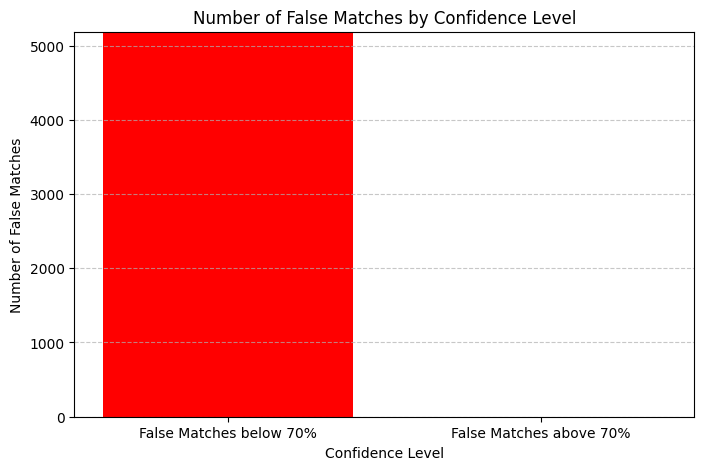

In [22]:
false_matches = final_matched_data[final_matched_data['sku'] != final_matched_data['matched_sku']]

# Count false matches below and above the threshold
false_below_threshold = false_matches[false_matches['confidence_score'] < threshold].shape[0]
false_above_threshold = false_matches[false_matches['confidence_score'] >= threshold].shape[0]

labels = ['False Matches below 70%', 'False Matches above 70%']
counts = [false_below_threshold, false_above_threshold]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['red', 'orange'])
plt.title('Number of False Matches by Confidence Level')
plt.xlabel('Confidence Level')
plt.ylabel('Number of False Matches')
plt.ylim(0, max(counts) + 10)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

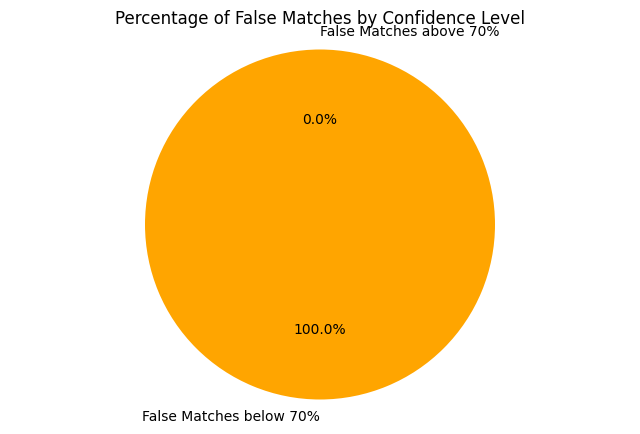

In [23]:
plt.figure(figsize=(8, 5))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['orange', 'red'])
plt.title('Percentage of False Matches by Confidence Level')
plt.axis('equal')  
plt.show()